In [28]:
import numpy as np

import torch
from torchvision import transforms

import beacon

from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import Generator3D

In [29]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [30]:
train_data = Generator3D.generate(300, 120, 92, 32).unsqueeze(1)
test_data = Generator3D.generate(300, 120, 92, 1).unsqueeze(1)

train_data_noisy = Generator3D.add_noise(train_data, p=0.0005)
test_data_noisy = Generator3D.add_noise(test_data, p=0.0005)

In [31]:
train_data.shape   # (batch size, features, t, x, y)

torch.Size([32, 1, 300, 120, 92])

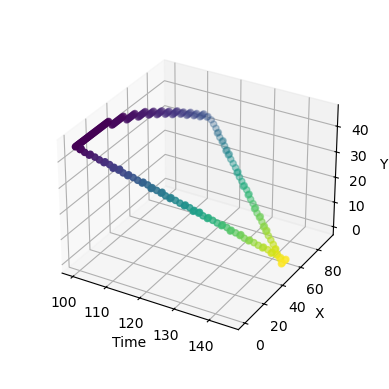

In [32]:
Generator3D.plot(train_data[0][0])

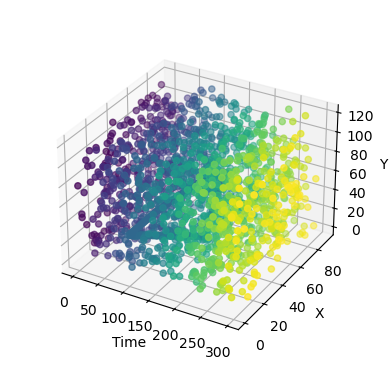

In [33]:
Generator3D.plot(train_data_noisy[0][0])

In [34]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv3d(1, 64, (3, 3, 3), stride=1),  # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv3d(64, 16, (3, 3, 3), stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv3d(16, 8, (3, 3, 3), stride=1), # Output: (64, 15, 12)
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(8, 16, (3, 3, 3), stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose3d(16, 64, (3, 3, 3), stride=1), # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose3d(64, 1, (3, 3, 3), stride=1), # Output: (1, 120, 90)
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [38]:
summary(ConvolutionAutoencoder(), input_size=(1, 1, 300, 120, 92))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv3d: 2]

In [36]:
# autoencoder = ConvolutionAutoencoder()
# autoencoder.compile(optimiser=torch.optim.Adam, loss_function=torch.nn.MSELoss, learning_rate=0.01, device=device)

In [37]:
# loss = autoencoder.fit_tensor(train_data_noisy, train_data, epochs=500)

  0%|          | 0/500 [00:01<?, ?it/s]


ValueError: expected 4D input (got 5D input)

In [39]:
autoencoder = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [40]:
autoencoder.train()

for epoch in tqdm(range(100)):
    optimiser.zero_grad()
    outputs = autoencoder(train_data_noisy.to(device))
    loss = loss_function(outputs, train_data.to(device))
    loss.backward()
    optimiser.step()

  0%|          | 0/100 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.04 GiB. GPU 

In [59]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data_noisy[0].unsqueeze(0).to("cpu"))

Text(0.5, 1.0, 'Reconstructed Image')

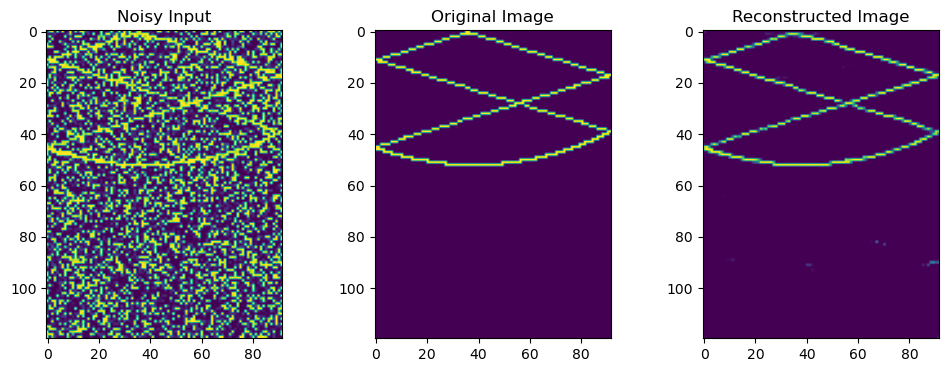

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_data_noisy[0][0].to("cpu"))
ax[1].imshow(test_data[0][0].to("cpu"))
ax[2].imshow(pred[0][0])

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")

In [7]:
test = np.array([[1, 2, 3], [4, 5, 6]])